
###We start by connecting to GoogleDrive, so we can access our data saved in the folder "Torque Prediction".



In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + r'/MyDrive/Colab Notebooks/Torque_Prediction'
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

else
  print("\nNot running in Googole Colab")

###First import all essential libraries and install tensorflow_addons.





In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from numpy import genfromtxt
from numba import njit, cuda,jit 
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
from pathlib import Path
import shutil
from skimage import color
from skimage import io


2022-12-14 14:06:47.545295: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


###Import essential Tensorflow - Keras Libraries.

In [3]:

import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.utils import plot_model, to_categorical, normalize
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()



### Check for available GPUs and configure Tensorflow session to utilize GPU. Change Runtime type to enable GPU hardware acceleration

In [4]:
from tensorflow.python.client import device_lib

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.compat.v1.InteractiveSession(config=config)
set_session(sess)
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(gpus))

2022-12-14 14:08:05.960178: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 14:08:06.459082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:11.189818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:11.190442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

Found GPU at: /device:GPU:0


2022-12-14 14:08:14.938595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:14.939807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:14.940379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:14.941121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:14.941228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1721] Could not ident

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1796187959665786268
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4716494848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15987521710975419441
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
Num GPUs Available:  1


2022-12-14 14:08:15.484389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:15.484942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:15.485307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:15.485926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 14:08:15.485948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1721] Could not ident

### Now import all the data from the CSV's.



In [7]:
#Collecting all datafields

df1=pd.read_csv(r'rec1_319.csv')
df2=pd.read_csv(r'rec1_343.csv')
df3=pd.read_csv(r'rec1_344.csv')
df4=pd.read_csv(r'rec1_369.csv')
df5=pd.read_csv(r'rec1_382.csv')
df6=pd.read_csv(r'rec1_383.csv')
df7=pd.read_csv(r'rec1_423.csv')
df8=pd.read_csv(r'rec1_430.csv')
df9=pd.read_csv(r'rec1_431.csv')
df10=pd.read_csv(r'rec1_446.csv')
df11=pd.read_csv(r'rec1_453.csv')

#Short Reminder: We want to predict torque of an electrical motor just by using the voltage and the current as an input. 
#Current parameters: id, iq
#Voltage parameters: vd, vq
input_names = ['id', 'iq', 'vd', 'vq']

#Put all interesting data (at least for us) together.
Input_Dataset = pd.concat([ df1[input_names],
                            df2[input_names],
                            df3[input_names],
                            df4[input_names],
                            df5[input_names],
                            df6[input_names],
                            df7[input_names],
                            df8[input_names],
                            df9[input_names],
                            df10[input_names],
                            df11[input_names],], axis=0)

print(Input_Dataset.shape)

target_names = ['Torque']
#Same for the output, which is just the torque.
Output_Dataset = pd.concat([ df1[target_names],
                            df2[target_names],
                            df3[target_names],
                            df4[target_names],
                            df5[target_names],
                            df6[target_names],
                            df7[target_names],
                            df8[target_names],
                            df9[target_names],
                            df10[target_names],
                            df11[target_names],], axis=0)

print(Output_Dataset.shape)



FileNotFoundError: [Errno 2] No such file or directory: 'rec1_319.csv'

###Bring the data into the right shape.

In [ ]:
#Renaming input parameters as it would be a function
X_data = Input_Dataset
Y_data = Output_Dataset

#Rescale all values to the unit interval with MinMaxScaler()
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_data_scaled = x_scaler.fit_transform(X_data)
Y_data_scaled = y_scaler.fit_transform(Y_data)

#Check the transform.
print("Min_Value for X_Data:", X_data_scaled.min())
print("Max_Value for X_Data:", X_data_scaled.max())
print("Min_Value for Y_Data:", Y_data_scaled.min())
print("Max_Value for Y_Data:", Y_data_scaled.max())

#Use a split of 80%. Hence 80% of the data for training, 20% for validation.
train_split = 0.8
x_train, x_test, y_train, y_test = train_test_split(X_data_scaled, Y_data_scaled, train_size=train_split, random_state=None, shuffle=True )
print()
print("Shape of training and testing vectors:")
print(x_train.shape, "  ", y_train.shape,"  ",  x_test.shape,"  ", y_test.shape)

Min_Value for X_Data: 0.0
Max_Value for X_Data: 1.0
Min_Value for Y_Data: 0.0
Max_Value for Y_Data: 0.9999999999999999

Shape of training and testing vectors:
(312096, 4)    (312096, 1)    (78025, 4)    (78025, 1)


### Check the distribution of training and test data by plotting every coloum.


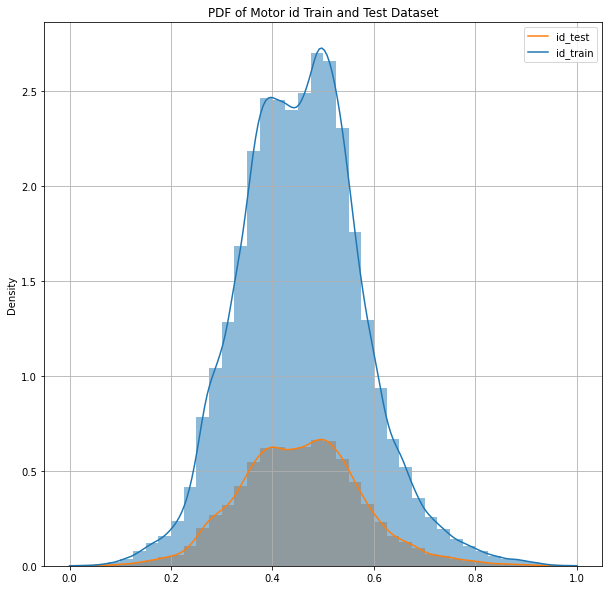

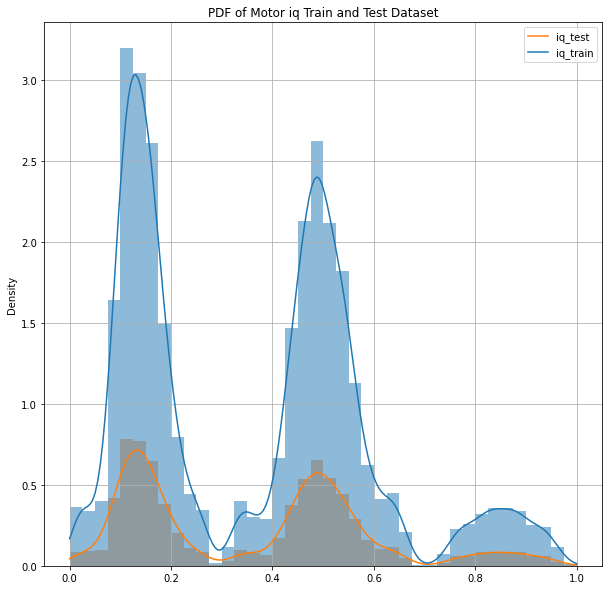

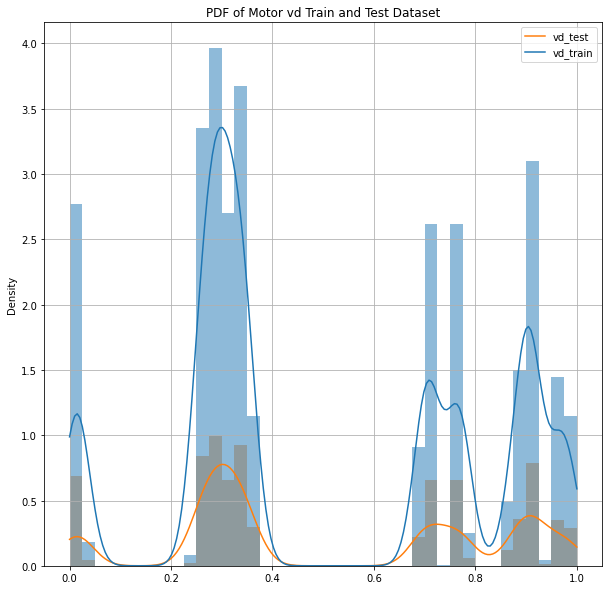

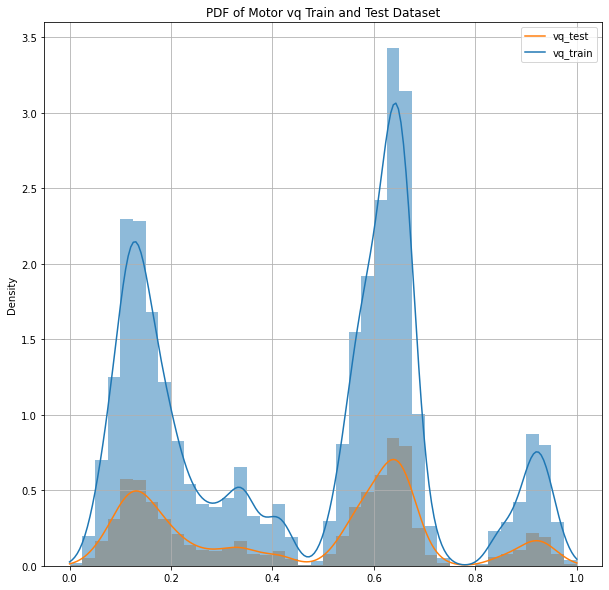

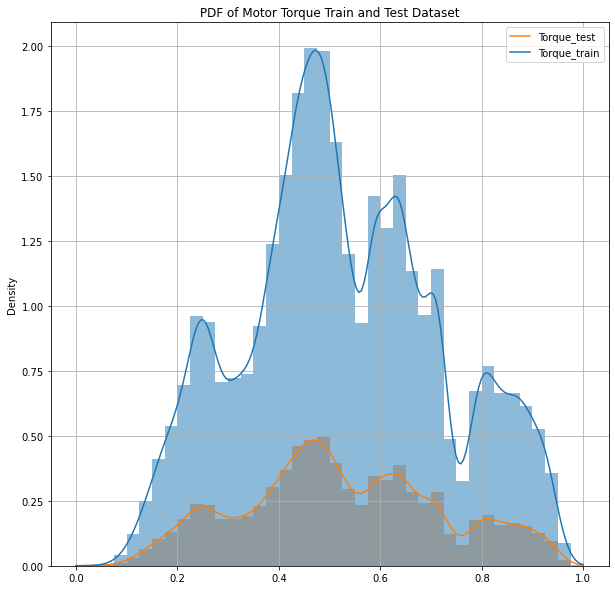

In [ ]:
#One can see, that training an testing data has almost the same distribution.
for i in range(len(input_names)):
  plt.figure(figsize=(10,10))
  sns.histplot([x_train[:,i],x_test[:,i]], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
  plt.legend([f'{input_names[i]}_test', f'{input_names[i]}_train'])
  plt.title(f'PDF of Motor {input_names[i]} Train and Test Dataset')
  plt.grid()
  plt.show()

for i in range(len(target_names)):
  plt.figure(figsize=(10,10))
  sns.histplot([y_train[:,i],y_test[:,i]], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
  plt.legend([f'{target_names[i]}_test', f'{target_names[i]}_train'])
  plt.title(f'PDF of Motor {target_names[i]} Train and Test Dataset')
  plt.grid()
  plt.show()


## Implement Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.
This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = r'Torque_Prediction_Model.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=False,
                                      restore_best_weights=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=40, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [ ]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", timestamp)
print(f'Tensorboard Logs Location: {logdir}')

callback_tensorboard = TensorBoard(logdir,
                                   histogram_freq=1,
                                   write_graph=True,
                                   profile_batch = '500,800')

%reload_ext tensorboard

Tensorboard Logs Location: logs/20220731-125513


This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=10`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.95 gives a learning-rate of 9.5e-4. We don't want the learning-rate to go any lower 1e-5

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.95,
                                       min_lr=1e-7,
                                       patience=10,
                                       verbose=1)    

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

###Set up plots for training history.

In [ ]:
#Plotting graphs for validation loss, mae, mape
with tf.device('/device:GPU:0'):
    def plot_train_history(history, title):
        plt.style.use('dark_background')

        loss = history.history['loss']
        mape = history.history['mape']
        mae = history.history['mae']
        val_loss = history.history['val_loss']
        val_mae = history.history['val_mae']
        val_mape = history.history['val_mape']
        epochs = range(len(loss))
        
        plt.figure(figsize=(30,5))
        plt.plot(epochs, loss, label='training_loss') 
        plt.plot(epochs, val_loss, label='validation_loss')
        plt.title('Loss')
        plt.legend(prop={'size': 30})
        plt.grid()
        plt.xticks(range(5), size=20)
        plt.show()

        plt.figure(figsize=(30,5))
        plt.plot(epochs, mae, label='training_mae') 
        plt.plot(epochs, val_mae, label='validation_mae')
        plt.title('MAE')
        plt.legend(prop={'size': 30})
        plt.grid()
        plt.xticks(range(5), size=20)
        plt.show()

        plt.figure(figsize=(30,5))
        plt.plot(epochs, mape, label='training_mape') 
        plt.plot(epochs, val_mape, label='validation_mape')
        plt.title('MAPE')
        plt.legend(prop={'size': 30})
        plt.grid()
        plt.xticks(range(5), size=20)
        plt.show()
        return



### Our first approach.

In [ ]:
#Simple model with one layer, containing 50 units.
#We first use the Adam optimizer with fixed learning rate 1e-3 and batch size of 32.

EPOCHS=5
 
model =  Sequential(name='Torque_Prediciton_Model')
model.add(Input(name='Input_Layer', shape=( x_train.shape[-1])))
model.add(Dense(units=50, activation='gelu', name='Hidden_Layer'))
model.add(Dense(units=y_train.shape[-1], activation='linear', name='Output_Layer'))

optimizer = Adam(learning_rate=1e-3, amsgrad=False)
model.compile(loss=['mae','mse','mape'], optimizer=optimizer, metrics=['mse', 'mape', 'mae'])
model.summary()

plot_model(model, show_shapes=True, to_file='Torque_Prediciton_model.png', show_layer_names=True, rankdir='TB', expand_nested=True, dpi=50)




### Second approach

In [ ]:
#This time 3 dense layers, 1 convolution layer and dropouts after each dense layer with dropout rate 0.01.

num_x_signals = len(input_names)

with tf.device('/device:GPU:0'):

    def create_model():
        inputs = tf.keras.Input(name='InputLayer', shape=(num_x_signals))
        dropout_rate=0.01
        num_units = 50
        

        x_encode = Dense(units=50,  activation='gelu', use_bias=True)(inputs)
        x_encode = tf.expand_dims((x_encode), axis=-2)
        x_encode = Conv1D(filters=50, kernel_size=4, strides=1, activation='gelu', data_format='channels_first')(x_encode)
        x_encode = Dropout(dropout_rate)(x_encode)
        x_encode = Dense(units=50,  activation='gelu', use_bias=True)(x_encode)
        x_encode = Dropout(dropout_rate)(x_encode)
        x_encode = Dense(units=50,  activation='gelu', use_bias=True)(x_encode)
        x_encode = Dropout(dropout_rate)(x_encode)
            
        x_encode = Flatten()(x_encode)
        x_encode = Dropout(dropout_rate)(x_encode)
        outputs = Dense(units=1,  activation='gelu', use_bias=True, name='Output_Layer')(x_encode)
        
        model = Model(inputs, outputs, name='Torque_Prediciton_model')
        optimizer = Adam(learning_rate=1e-3, amsgrad=False)
        model.compile(loss=['mae','mse','mape'], optimizer=optimizer, metrics=['mse', 'mape', 'mae'])
        model.build((None, 1, num_x_signals))

        return model

    model = create_model()
    model.summary()

    plot_model(model, show_shapes=True, to_file='Torque_Prediciton_model.png', show_layer_names=True, rankdir='TB', expand_nested=True, dpi=50)
    


Model: "Torque_Prediciton_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 50)                250       
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 50, 47)            250       
                                                                 
 dropout (Dropout)           (None, 50, 47)            0         
                                                                 
 dense_1 (Dense)             (None, 50, 50)            2400      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)

### Final approach

In [ ]:
#The final approach got 5 CNNs, 100 - 10/step unit DNNs and dropout layers with dropout rate 0.2
#Best results with batch size 256 

num_x_signals = len(input_names)
num_y_signals = len(target_names)

with tf.device('/device:GPU:0'):

    def create_model():
        inputs = keras.Input(name='InputLayer', shape=(num_x_signals))
        dropout=0.2
        num_layers=5
        num_units = 100
        steps = 10

        x_encode = Dense(units=num_units,  activation='relu', use_bias=True)(inputs)
        x_encode = tf.expand_dims((x_encode), axis=-2)
        x_encode = Conv1D(filters=num_units, kernel_size=4, strides=1, activation='selu', data_format='channels_first')(x_encode)
        x_encode = Dropout(dropout)(x_encode)

        for i in range(num_layers):
            num_units = num_units - steps
            x_encode = Dense(units=num_units,  activation='relu', use_bias=True)(x_encode)
            x_encode = Conv1D(filters=num_units, kernel_size=4, strides=1, activation='selu', data_format='channels_first')(x_encode)
            x_encode = Dropout(dropout)(x_encode)
            
            
        x_encode = Flatten()(x_encode)
        x_encode = Dropout(dropout)(x_encode)
        
        outputs = Dense(units=num_y_signals,  activation='relu', use_bias=True, name='Output_Layer')(x_encode)
        
        optimizer = Adam(learning_rate=1e-2, amsgrad=True) 
        model = Model(inputs, outputs, name='Torque_Prediciton_model')
        model.compile(loss=['mae','mse','mape'], optimizer=optimizer, metrics=['mae', 'mse','mape'])
        model.build((None, 1, num_x_signals))

        return model

    model = create_model()
    model.summary()

    plot_model(model, show_shapes=True, to_file='Torque_Prediciton_model.png', show_layer_names=True, rankdir='TB', expand_nested=True, dpi=50)

Model: "Torque_Prediciton_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 100)               500       
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 1, 100)           0         
 a)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 97)           500       
                                                                 
 dropout_4 (Dropout)         (None, 100, 97)           0         
                                                                 
 dense_4 (Dense)             (None, 100, 90)           8820      
                                           

### Train the chosen model.

In [ ]:
#Load an old model or train the actual one.

EPOCHS = 5
BATCH_SIZE = 32

for _ in range(1):
  try:
    # model.save((f'Torque_Prediction_Model_{timestamp}.h5', {"CustomLoss": CustomLoss}))
    #model.load_weights(f'Torque_Prediction_Model_{timestamp}.h5', {"CustomLoss": CustomLoss})
    model = load_model(f'Torque_Prediction_Model_{timestamp}.h5', {"CustomLoss": ['mae','mse','mape']})
    print("Checkpoint Loaded")
  except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
    

history = model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=callbacks,
                validation_split = 0.2,
                verbose=1,
                workers=2, 
                use_multiprocessing=True,
                shuffle=True)    
plot_train_history(history, 'Model Training History')
model.history

Error trying to load checkpoint.
name 'timestamp' is not defined
Epoch 1/5
1274/7803 [===>..........................] - ETA: 2:10 - loss: 0.5362 - mae: 0.5362 - mse: 0.4935 - mape: 102.8092

KeyboardInterrupt: ignored

### Launch tensorboard


In [ ]:
!pip install -U tensorboard-plugin-profile

%tensorboard --logdir logs

### Save Model

In [ ]:
model.save(r'Torque_Prediction_Model.h5')

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
try:
    model = load_model(r'Torque_Prediction_Model.h5', {"CustomLoss": ['mae','mse','mape']})
    model.load_weights(r'Torque_Prediction_Model.h5', {"CustomLoss": ['mae','mse','mape']})
    print("Checkpoint Loaded")
except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)

Checkpoint Loaded


## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [ ]:
with tf.device('/device:GPU:0'):
    model.evaluate(x_train, y_train, verbose=1)
    model.evaluate(x_test, y_test, verbose=1)

2439/2439 [==============================] - 7s 3ms/step - loss: 0.0825 - mse: 0.0275 - mape: 15.5149 - mae: 0.0825


4/4 [==============================] - 0s 3ms/step


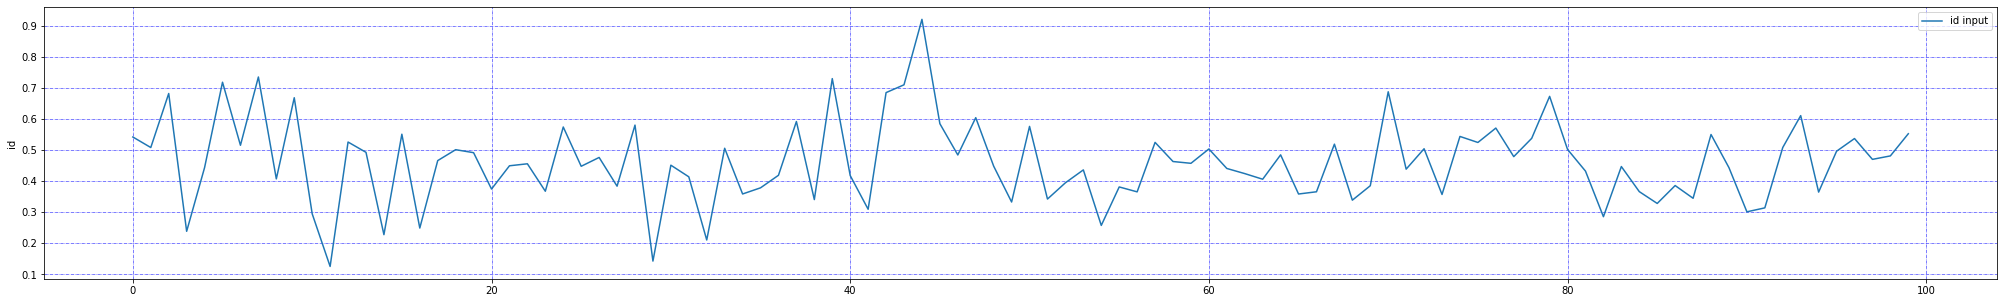

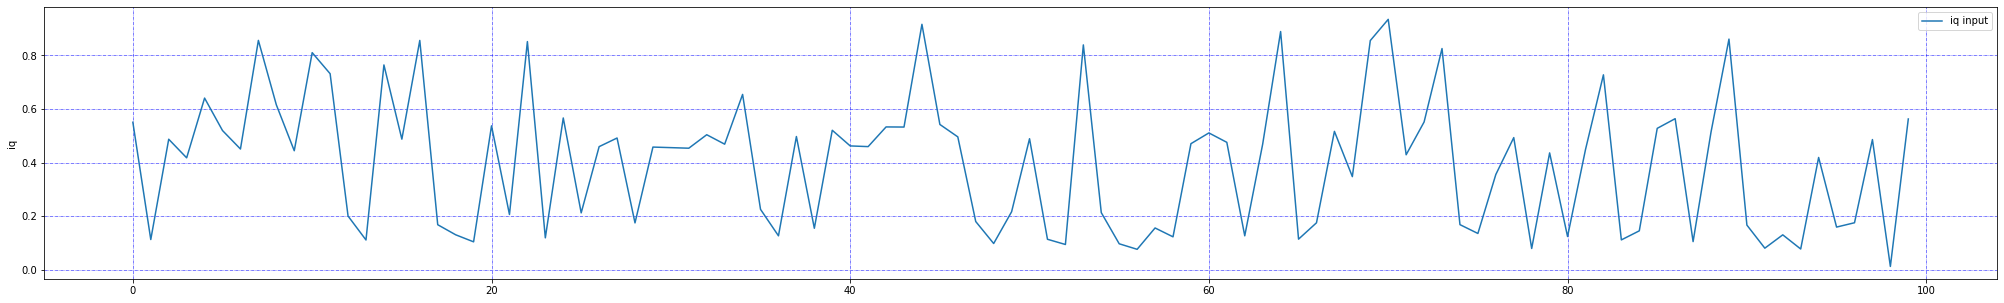

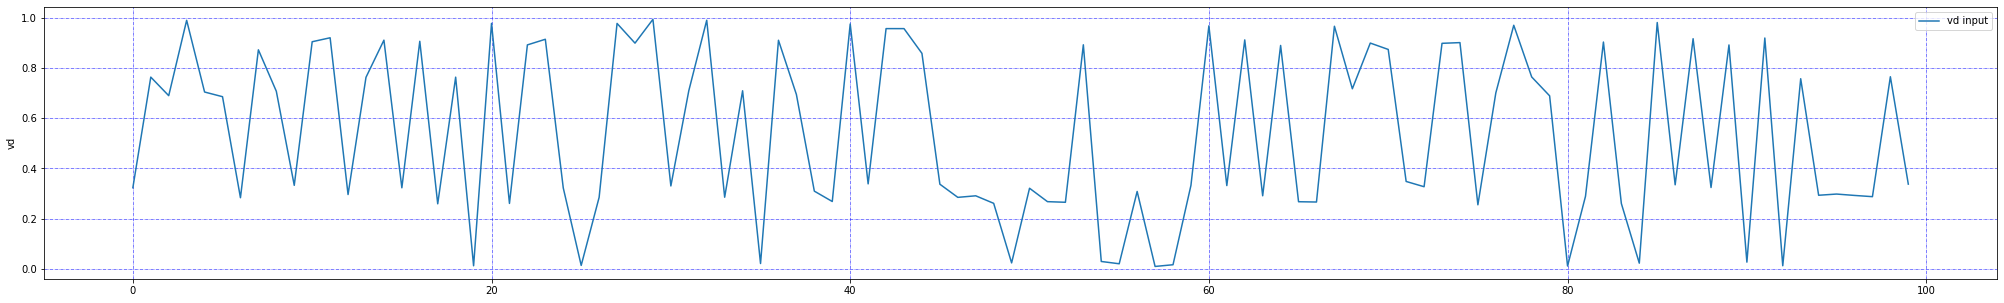

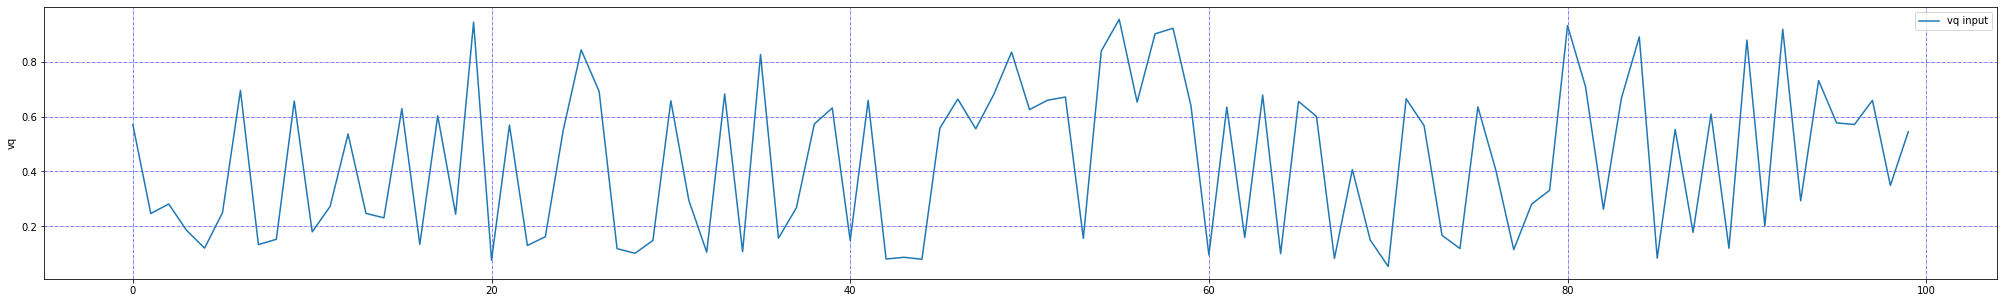

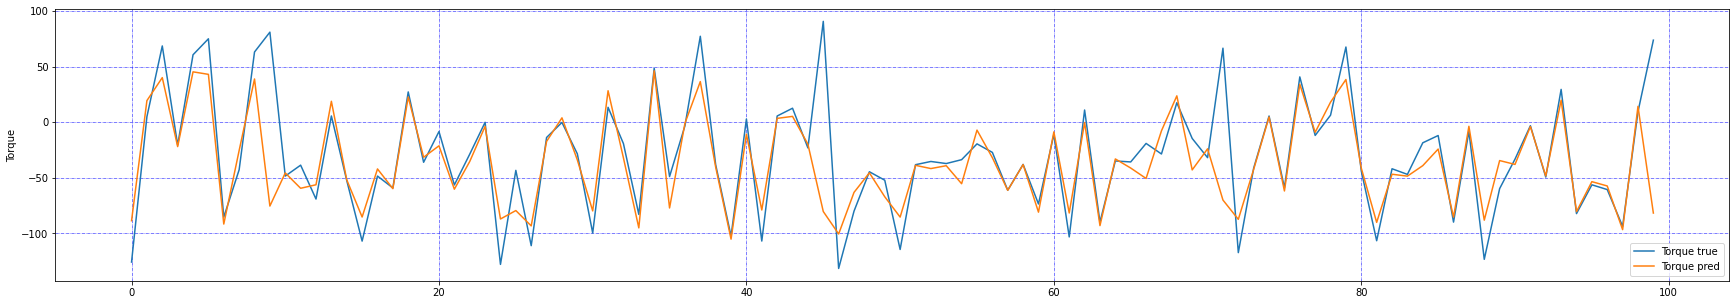

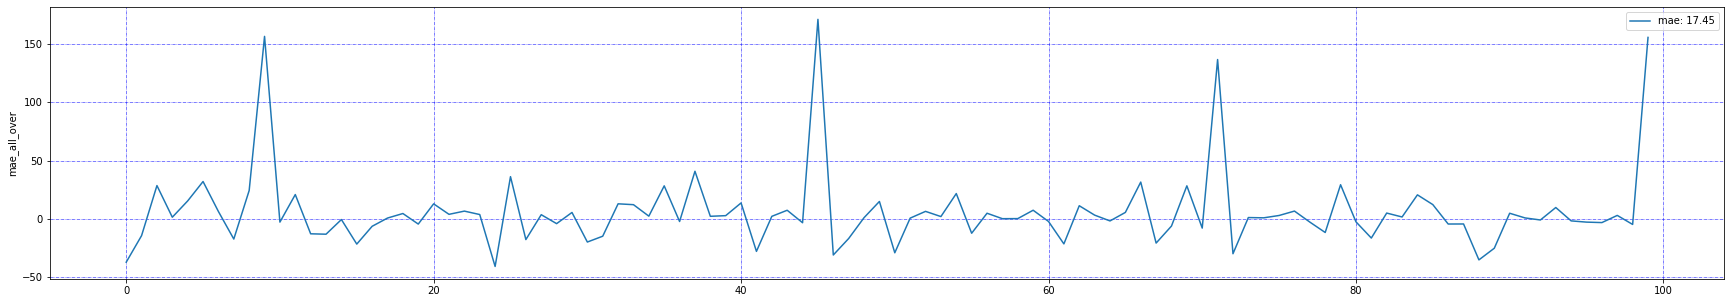

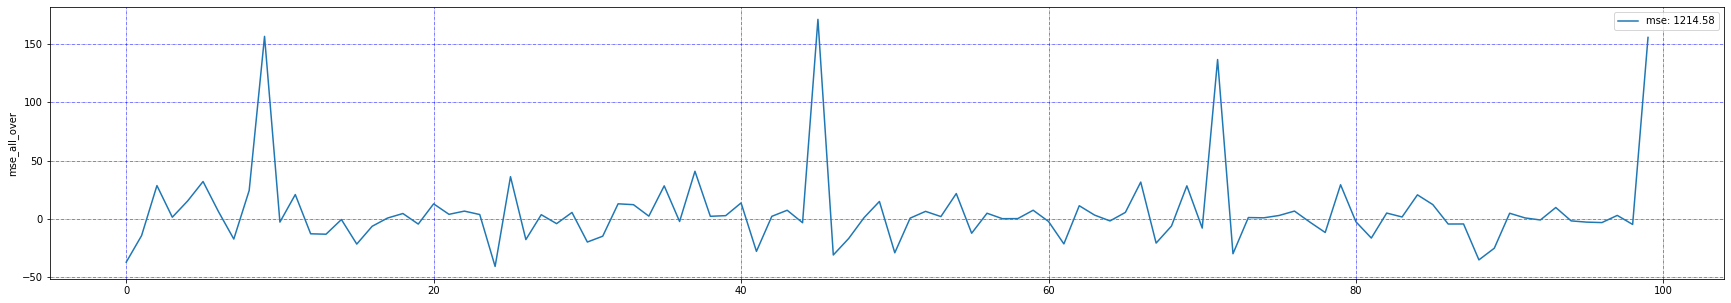

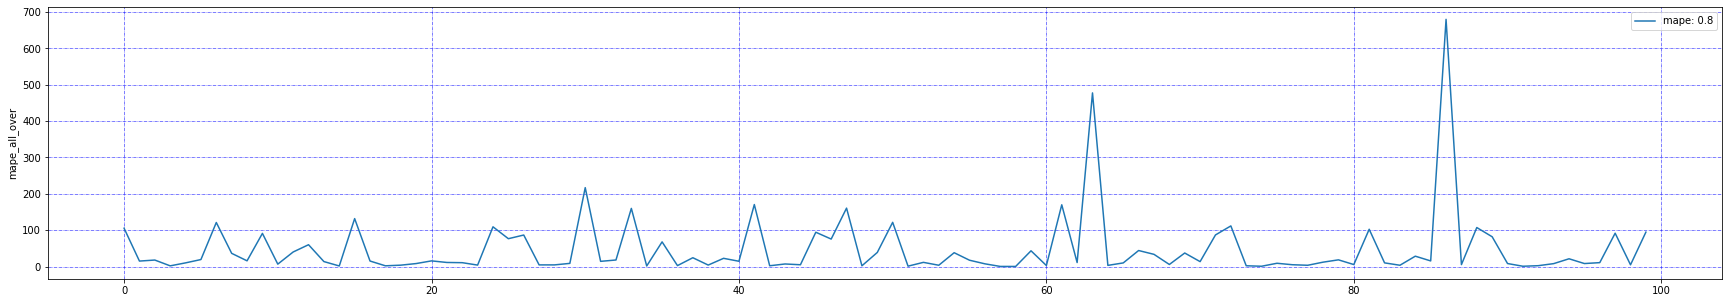

<Figure size 2160x360 with 0 Axes>

In [ ]:
# Plot and compare the predicted and real torques.
#Plot the loss functions at each timestep.

import sklearn

warmup_steps=0
start_idx = 10000
test_length = 100
rho = 0.05
sr = 10000

with tf.device('/device:GPU:0'):
        mape = tf.keras.losses.MeanAbsolutePercentageError()
        sequence_length=100

        x_input = x_test[start_idx:start_idx+test_length]
        y_pred = model.predict(x_input, verbose=1)
        y_true = y_scaler.inverse_transform(y_test[start_idx:start_idx+test_length])   
        y_pred = y_scaler.inverse_transform(y_pred)

       
for signal_ in range(len(input_names)):
               
        # Get the true output-signal from the data-set.
        signal_input = x_input[:, signal_]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(35,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_input, label=f'{input_names[signal_]} input')
   
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(input_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()


for signal_ in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred[:, signal_]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal_]
        
        error = np.zeros(len(signal_true))
        p_error = np.zeros(len(signal_true))

        for i in range(len(signal_true)):
            error[i] = signal_true[i]-signal_pred[i]
            p_error[i] = mape((signal_true[i]+max(signal_true)).reshape(-1,1), (signal_pred[i]+max(signal_true)).reshape(-1,1))

        mae_all_over = sklearn.metrics.mean_absolute_error(signal_true,signal_pred)
        mape_all_over = sklearn.metrics.mean_absolute_percentage_error(signal_true,signal_pred)
        mse_all_over = sklearn.metrics.mean_squared_error(signal_true, signal_pred)
       
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(30,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label=f'{target_names[signal_]} true')
        plt.plot(signal_pred, label=f'{target_names[signal_]} pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()
        
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(30,5))
        
        # Plot and compare the two signals.
        plt.plot(error, label=f'mae: {np.round(mae_all_over,2)}')
                
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel("mae_all_over")
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(30,5))

        plt.plot(error, label=f'mse: {np.round(mse_all_over,2)}')
                
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel("mse_all_over")
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(30,5))
        
        # Plot and compare the two signals.
        plt.plot(p_error, label=f'mape: {np.round(mape_all_over, 2)}')
        
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        plt.ylabel("mape_all_over")
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()
        # RMSE ERROR
        # Make the plotting-canvas bigger. 
        plt.figure(figsize=(30,5))

### Output of the first 100 torque values. Predicted and real ones, not retransformed.

In [ ]:
output = model.predict(x_test[:100], verbose=1) 

y_true = y_test[:100]
y_pred = output

plt.figure(figsize=(30,5))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])
plt.show()

### Output of the first 100 torque values but this time retransformed.

In [ ]:
y_true = y_scaler.inverse_transform(y_test[:100])
y_pred = y_scaler.inverse_transform(output)

plt.figure(figsize=(30,10))
plt.plot(y_true)
plt.plot(y_pred)
plt.yticks(range(-150, 100, 10))
plt.yticks(range(-150, 100, 10))
plt.grid()
plt.legend(['y_true','y_pred'])
plt.show()